# Choose the metric and split the data (1 / 3 part)

In [1]:
from config import connection
from typing import Union
from hashlib import md5

import pandas as pd
import pandahouse as ph
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})

## 1. Decide, what metric should be increased?
Suppose we want to check a new recomendation system, that it makes users click on 'like' button more times, than before. For that task we should use the CTR metric, that can be simply calculated as the count of likes divided by count of views, grouped by each user. How to split users by groups will be shown in the 2nd part, for now we already have users, splitted by different groups, so lets take 2 and 3 group only. 



In [2]:
# Date range before the experiment
first_date = '2022-07-06'
last_date = '2022-07-12'

metric = f"""
    SELECT
        user_id,
        exp_group,
        countIf(action='like') / countIf(action='view') as ctr
    FROM
        simulator_20220820.feed_actions
    WHERE
        toDate(time) between '{first_date}' and '{last_date}' AND
        exp_group IN [2, 3]
    GROUP BY
        user_id, exp_group
"""

In [3]:
df = ph.read_clickhouse(metric, connection=connection)
df.head()

,user_id,exp_group,ctr
0,115383,3,0.305556
1,123580,3,0.163043
2,131473,2,0.175676
3,23985,2,0.181818
4,24523,2,0.141667


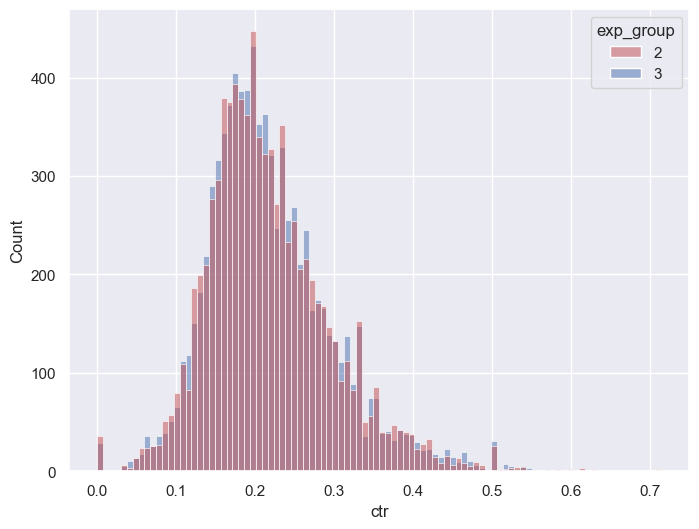

In [4]:
sns.histplot(
    data=df,
    x='ctr',
    hue='exp_group',
    palette = ['r', 'b'],
    alpha=0.5,
    kde=False
);

## 2. Manually split the data on groups
Here will be shown the method how to split the data on different groups, using Python or Clickhouse. This step is optional as we have already different groups in our database, but we'll split the data just to be sure how it works.

In [5]:
def show_group_info(data: pd.DataFrame, groups: list = [2, 3]):
    """This method shows, how our data was splitted by groups 
    and shows distribution plot to check if our data seems identical"""
    print("\n[INFO] The experimental value counts group distribution:")
    print((data['exp_group'].value_counts(normalize=True).sort_index() * 100).to_frame().T)

    # Get 2nd and 3rd groups (or whatever we choose)
    data_by_groups = data[data['exp_group'].isin(groups)]
    sns.histplot(
        data=data_by_groups,
        x='ctr',
        hue='exp_group',
        palette = ['r', 'b'],
        alpha=0.5,
        kde=False
    );
    return

### 2.1. Python method

In [6]:
# Python hash function
def get_group(user_id: Union[int, str], salt: str = "experiment", n_groups: int = 5):
    """
    Return group number for specified user_id. 
    The salt variable may be specified for different experiments.
    """
    stack_id = str(user_id) + "_" + salt
    md5_id = md5(stack_id.encode('ascii')).hexdigest()
    hashed_id = int(md5_id, 16)
    return hashed_id % n_groups

In [7]:
get_users_query = f"""
SELECT
    user_id,
    countIf(action='like') / countIf(action='view') as ctr
FROM
    simulator_20220820.feed_actions
WHERE
    toDate(time) between '{first_date}' and '{last_date}'
GROUP BY
    user_id
"""

ctr_data = ph.read_clickhouse(get_users_query, connection=connection)
ctr_data.head()

,user_id,ctr
0,13289,0.127273
1,121096,0.287129
2,5090,0.378788
3,129283,0.117647
4,129995,0.236842


In [8]:
# Split on groups using Python function and Pandas apply method
ctr_data['exp_group'] = ctr_data['user_id'].apply(get_group)
ctr_data.head()

,user_id,ctr,exp_group
0,13289,0.127273,1
1,121096,0.287129,2
2,5090,0.378788,3
3,129283,0.117647,2
4,129995,0.236842,3



[INFO] The experimental value counts group distribution:
                   0         1          2          3          4
exp_group  19.896677  20.09393  19.861454  20.274745  19.873195


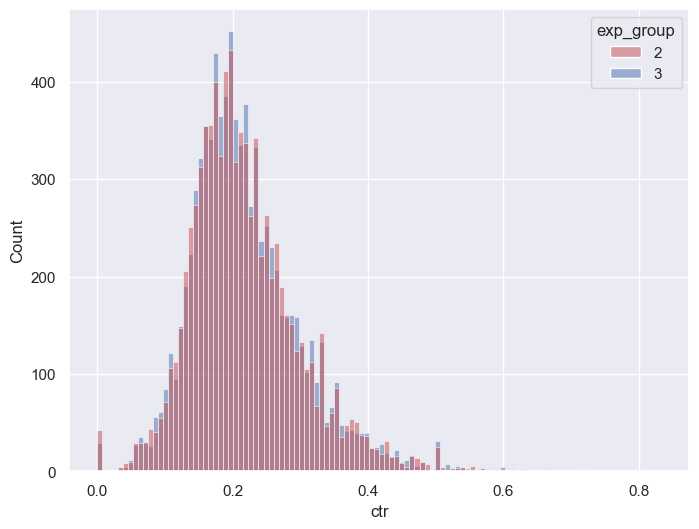

In [9]:
show_group_info(ctr_data)

### 2.2 Clickhouse method

In [10]:
# Get experimental groups right in the Clickhouse
get_users_query = f"""
SELECT
    user_id,
    countIf(action='like') / countIf(action='view') as ctr,
    xxHash64(toString(user_id)||'my_salt') % 5 as exp_group -- Split on 5 groups
FROM
    simulator_20220820.feed_actions
WHERE
    toDate(time) between '{first_date}' and '{last_date}'
GROUP BY
    user_id
"""

ctr_data = ph.read_clickhouse(get_users_query, connection=connection)
ctr_data.head()

,user_id,ctr,exp_group
0,13289,0.127273,3
1,121096,0.287129,4
2,5090,0.378788,2
3,129283,0.117647,0
4,129995,0.236842,1



[INFO] The experimental value counts group distribution:
                   0          1          2          3          4
exp_group  20.082189  19.950687  19.938946  20.098626  19.929553


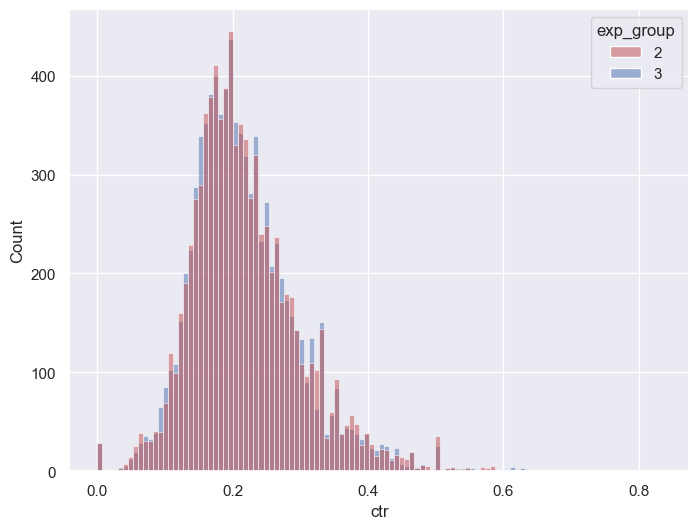

In [11]:
show_group_info(ctr_data)

### Summary:
After splitting the data on experimental groups, we can see, that our data are almost identical. This means that our split system seems to be working fine.